In [131]:
import pandas as pd
from matplotlib import rcParams
import seaborn as sns
import numpy as np
from PIL import Image
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Layer
# import torch
# import torch.nn as nn
import re
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.ops.numpy_ops import np_utils
# from transformers import BertModel, TFBertModel 
# import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel, DistilBertTokenizer, TFDistilBertModel, AutoTokenizer
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk


In [132]:
# downloaded from https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets/data
fake_data=pd.read_csv("./input/Fake.csv")
real_data=pd.read_csv("./input/True.csv")

In [133]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [134]:
real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [135]:
def remove_duplicates(df, column):
    initial_rows = len(df)
    df_unique = df.drop_duplicates(subset=[column])
    final_rows = len(df_unique)
    removed_rows = initial_rows - final_rows
    print(f"Number of removed duplicate {column}s: {removed_rows}")
    return df_unique

In [136]:
print("Fake Data:")
fake_data = remove_duplicates(fake_data, 'title')
fake_data = remove_duplicates(fake_data, 'text')
print("\nReal Data:")
real_data = remove_duplicates(real_data, 'title')
real_data = remove_duplicates(real_data, 'text')

Fake Data:
Number of removed duplicate titles: 5578
Number of removed duplicate texts: 453

Real Data:
Number of removed duplicate titles: 591
Number of removed duplicate texts: 5


/tmp/ipykernel_5006/88201135.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_data_plot['date_ordinal'] = fake_data_plot['date'].apply(lambda x: x.toordinal())
/tmp/ipykernel_5006/88201135.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_data_plot['Group'] = 'Fake'
/tmp/ipykernel_5006/88201135.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_labels, rotation=45)


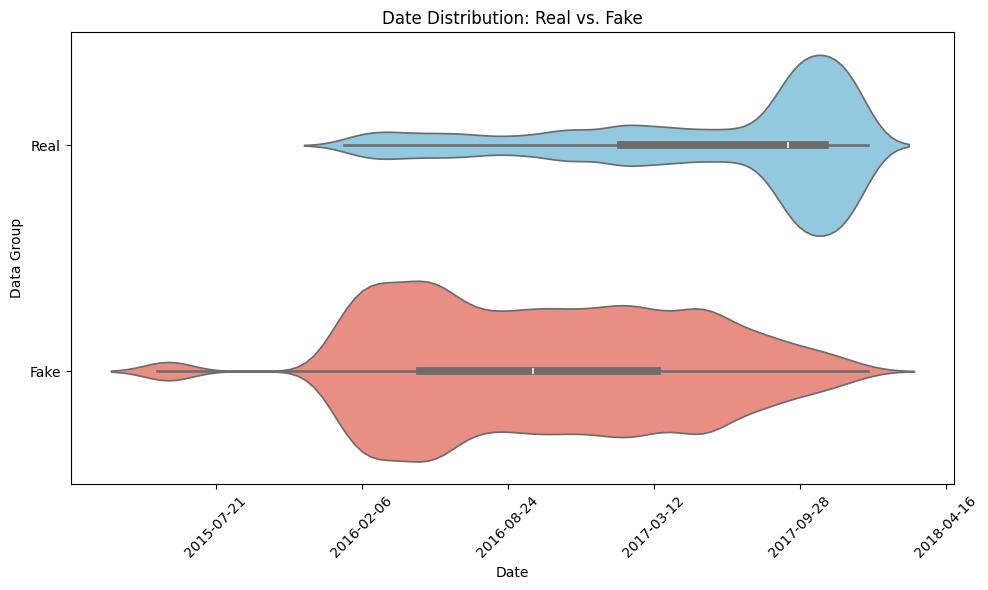

In [137]:
# Convert the 'date' columns to datetime.
real_data['date'] = pd.to_datetime(real_data['date'].str.strip(), format="%B %d, %Y", errors='coerce')
fake_data['date'] = pd.to_datetime(fake_data['date'].str.strip(), format="%B %d, %Y", errors='coerce')

# Define a valid date range.
valid_min = pd.to_datetime("2000-01-01")
valid_max = pd.to_datetime("2020-12-31")

# Filter out rows with dates outside the valid range.
real_data_plot = real_data[(real_data['date'] >= valid_min) & (real_data['date'] <= valid_max)]
fake_data_plot = fake_data[(fake_data['date'] >= valid_min) & (fake_data['date'] <= valid_max)]

# Convert dates to ordinal numbers for plotting.
real_data_plot['date_ordinal'] = real_data_plot['date'].apply(lambda x: x.toordinal())
fake_data_plot['date_ordinal'] = fake_data_plot['date'].apply(lambda x: x.toordinal())

# Add a column to distinguish between real and fake data.
real_data_plot['Group'] = 'Real'
fake_data_plot['Group'] = 'Fake'

# Combine the dataframes.
combined = pd.concat([real_data_plot, fake_data_plot])

# Create a horizontal violin plot.
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='date_ordinal', y='Group', data=combined,
                    palette={'Real': 'skyblue', 'Fake': 'salmon'}, orient='h', hue='Group', legend=False)

plt.title("Date Distribution: Real vs. Fake")
plt.xlabel("Date")
plt.ylabel("Data Group")

# Adjust x-axis ticks to show formatted dates.
ticks = ax.get_xticks()
tick_labels = [pd.Timestamp.fromordinal(int(t)).strftime("%Y-%m-%d") for t in ticks]
ax.set_xticklabels(tick_labels, rotation=45)

plt.tight_layout()
plt.show()

In [138]:
print("News Subjects:")
print(f"-> Real News:\n{real_data['subject'].value_counts()}")
print(f"\n-> Fake News:\n{fake_data['subject'].value_counts()}")

News Subjects:
-> Real News:
subject
politicsNews    11147
worldnews        9674
Name: count, dtype: int64

-> Fake News:
subject
News               9049
politics           6421
US_News             783
left-news           683
Government News     514
Name: count, dtype: int64


<Axes: title={'center': 'Subjects - Real News'}, ylabel='subject'>

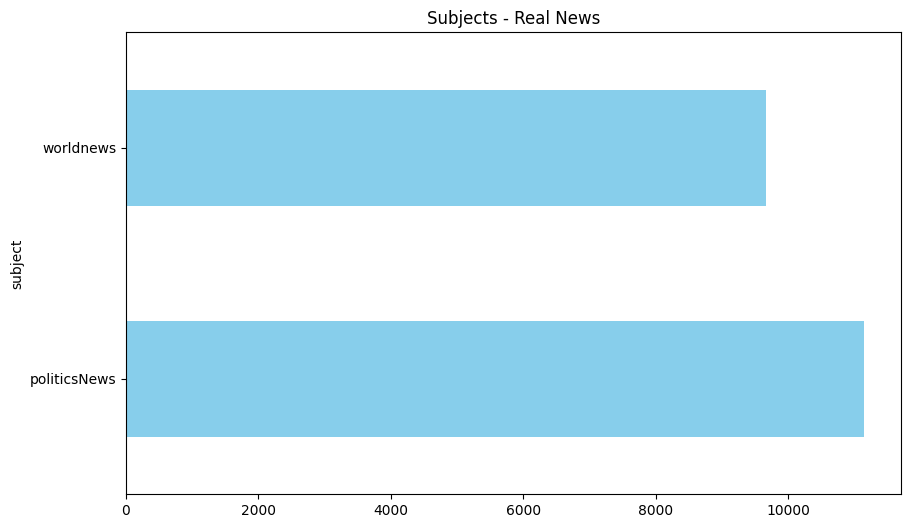

In [139]:
real_data['subject'].value_counts().plot(kind='barh', title='Subjects - Real News', color='skyblue', figsize=(10, 6))

<Axes: title={'center': 'Subjects - Fake News'}, ylabel='subject'>

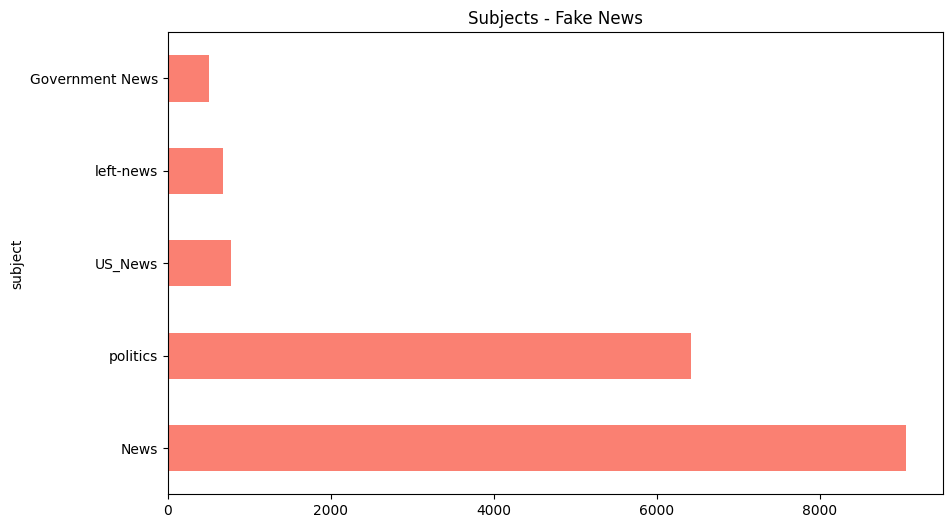

In [140]:
fake_data['subject'].value_counts().plot(kind='barh', title='Subjects - Fake News', color='salmon', figsize=(10, 6))

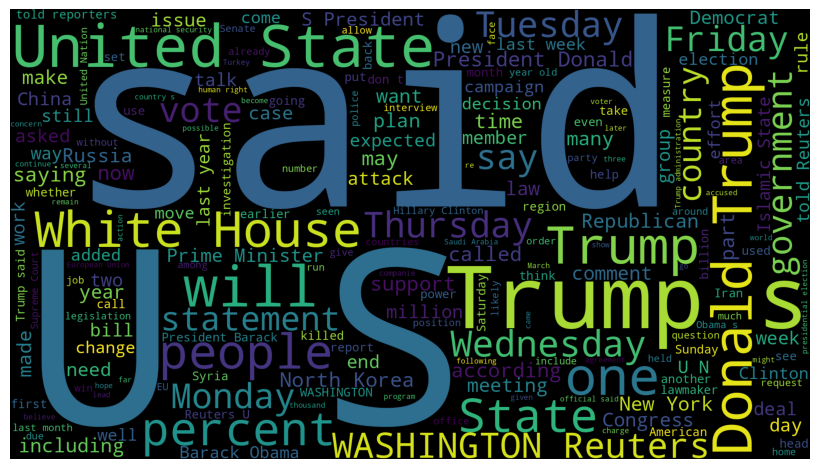

In [141]:
# REAL DATA
wordcld_text=" ".join(real_data["text"].tolist())
wordcloud=WordCloud(width=1920,height=1080).generate(wordcld_text)
fig=plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

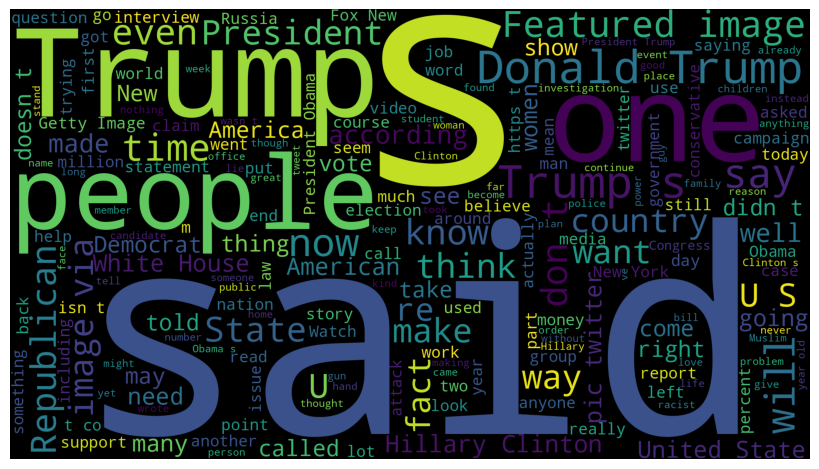

In [142]:
# FAKE DATA
wordcld_text=" ".join(fake_data["text"].tolist())
wordcloud=WordCloud(width=1920,height=1080).generate(wordcld_text)
fig=plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [143]:
# 631 times only headline available
print("Missing texts in real_data:", len(real_data[real_data["text"].str.strip() == ""]))
print("Missing texts in fake_data:", len(fake_data[fake_data["text"].str.strip() == ""]))

Missing texts in real_data: 1
Missing texts in fake_data: 2


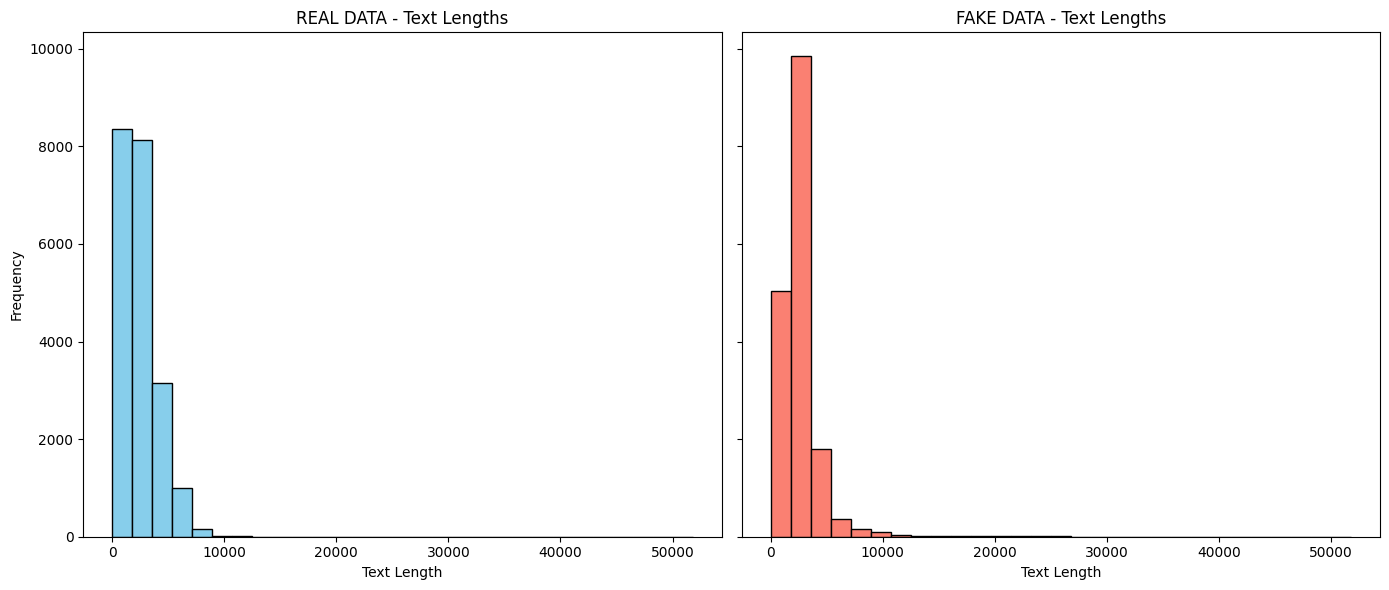

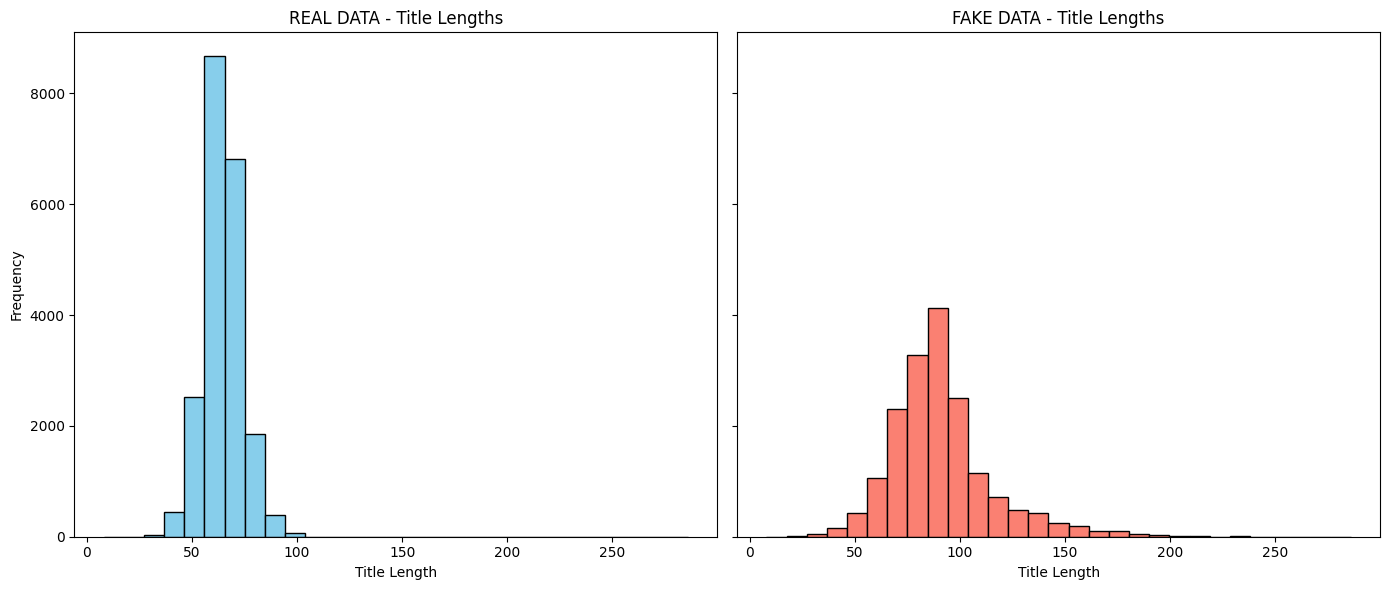

In [144]:
real_data['text_length'] = real_data['text'].apply(len)
real_data['title_length'] = real_data['title'].apply(len)
fake_data['text_length'] = fake_data['text'].apply(len)
fake_data['title_length'] = fake_data['title'].apply(len)

# Define bin ranges based on combined min/max values
text_min = min(real_data['text_length'].min(), fake_data['text_length'].min())
text_max = max(real_data['text_length'].max(), fake_data['text_length'].max())

title_min = min(real_data['title_length'].min(), fake_data['title_length'].min())
title_max = max(real_data['title_length'].max(), fake_data['title_length'].max())

# Define bin edges for consistent intervals
text_bins = np.linspace(text_min, text_max, 30)  # Adjust 30 for desired granularity
title_bins = np.linspace(title_min, title_max, 30)

# For Text Lengths Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
axes[0].hist(real_data['text_length'], bins=text_bins, color='skyblue', edgecolor='black')
axes[0].set_title('REAL DATA - Text Lengths')
axes[0].set_xlabel('Text Length')
axes[0].set_ylabel('Frequency')

axes[1].hist(fake_data['text_length'], bins=text_bins, color='salmon', edgecolor='black')
axes[1].set_title('FAKE DATA - Text Lengths')
axes[1].set_xlabel('Text Length')

plt.tight_layout()
plt.show()

# For Title Lengths Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
axes[0].hist(real_data['title_length'], bins=title_bins, color='skyblue', edgecolor='black')
axes[0].set_title('REAL DATA - Title Lengths')
axes[0].set_xlabel('Title Length')
axes[0].set_ylabel('Frequency')

axes[1].hist(fake_data['title_length'], bins=title_bins, color='salmon', edgecolor='black')
axes[1].set_title('FAKE DATA - Title Lengths')
axes[1].set_xlabel('Title Length')

plt.tight_layout()
plt.show()

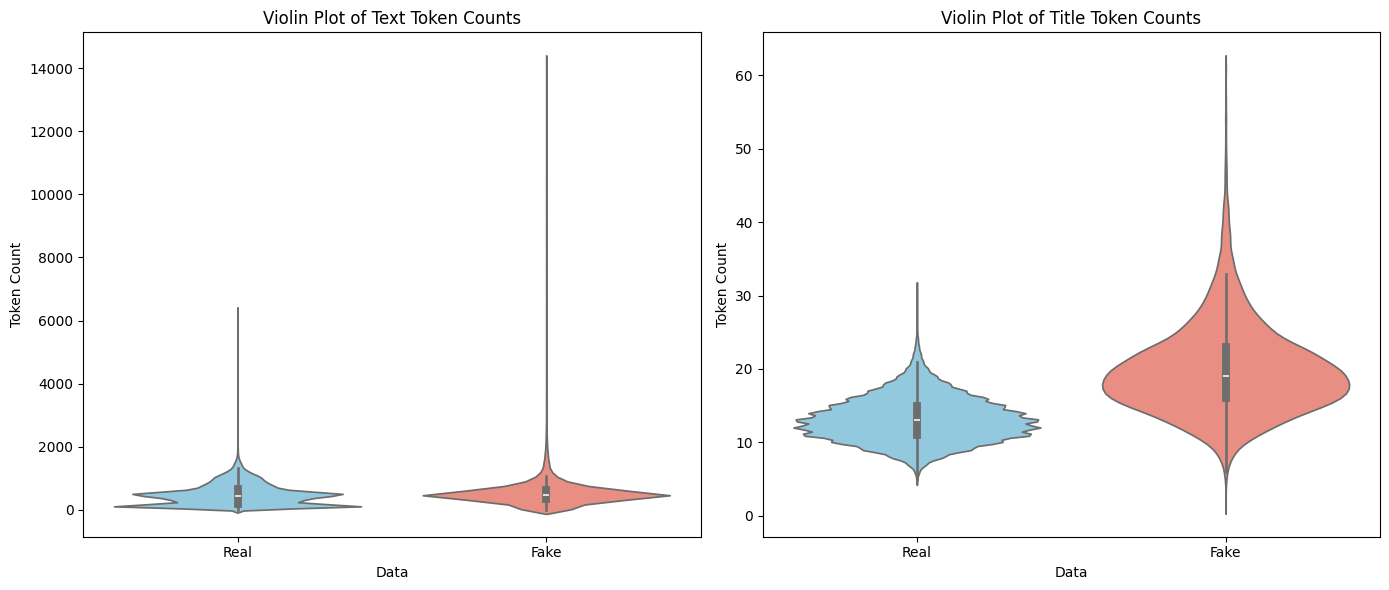

In [145]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Compute token counts for both real and fake data for 'text' and 'title'.
real_data['text_token_count'] = real_data['text'].apply(lambda x: len(tokenizer.tokenize(x)))
real_data['title_token_count'] = real_data['title'].apply(lambda x: len(tokenizer.tokenize(x)))

fake_data['text_token_count'] = fake_data['text'].apply(lambda x: len(tokenizer.tokenize(x)))
fake_data['title_token_count'] = fake_data['title'].apply(lambda x: len(tokenizer.tokenize(x)))

# Prepare DataFrames for violin plots.
df_text_tokens = pd.DataFrame({
    'Token Count': list(real_data['text_token_count']) + list(fake_data['text_token_count']),
    'Data': ['Real'] * len(real_data) + ['Fake'] * len(fake_data)
})

df_title_tokens = pd.DataFrame({
    'Token Count': list(real_data['title_token_count']) + list(fake_data['title_token_count']),
    'Data': ['Real'] * len(real_data) + ['Fake'] * len(fake_data)
})

# Create violin plots side by side for texts and titles.
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Violin plot for text token counts.
sns.violinplot(x='Data', y='Token Count', data=df_text_tokens, 
               ax=axes[0], palette={'Real': 'skyblue', 'Fake': 'salmon'}, hue='Data', legend=False)
axes[0].set_title('Violin Plot of Text Token Counts')
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Token Count')

# Violin plot for title token counts.
sns.violinplot(x='Data', y='Token Count', data=df_title_tokens, 
               ax=axes[1], palette={'Real': 'skyblue', 'Fake': 'salmon'}, hue='Data', legend=False)
axes[1].set_title('Violin Plot of Title Token Counts')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Token Count')

plt.tight_layout()
plt.show()

## Preprocessing

Extreme Bias due to "(Reuters)":

In [146]:
# check real_data for indicators other than just the text for being real
count = real_data["text"].str.contains(r"\(Reuters\)").sum()
print(f"The percentage of real news articles containing '(Reuters)': {np.round(count/len(real_data)*100,2)}%")

The percentage of real news articles containing '(Reuters)': 99.22%


In [147]:
# Define pattern variables.
city_reuters_pattern = r'^(\(.*\))*\s*[A-Z][A-Z\s,./-]*\(Reuters\)\s*-\s*'
timestamp_pattern = r'\[\d{3,4}\s+\w+\]'
dates_pattern = r'\((?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)(\.)?\s\d+\)'
source_links_pattern = r'\s*--\s*Source link:\s*(?:\([^)]+\)\s*)+$'
bitly_links_pattern = r'bit\.ly/[^\)\]\s]+'
reuters_pattern = r'\(Reuters\) -'
social_tag_pattern = r'\(\@\w+\)'
special_char_pattern = r'\@'
unicode_control_chars_pattern = r'[\u200E\u200F\u202A-\u202E]'
headline_keywords_pattern = (r'(WATCH|BREAKING|WTF|BUSTED|EMBARASSING|WTF|WHOA|OOPS|'
                             r'EXPOSED|REVEALED|BOMBSHELL|CORRUPTION|YOU’RE FIRED|WEIRD|'
                             r'SPINELESS|VINDICATION|UNHINGED|UNPRECEDENTED|CREEPY|LOL|ALERT|'
                             r'WOW|Unbelievable|UNCOVERED|SICK|RIGGED|OUTRAGE|MUTINY|'
                             r'SICKENING|FACEPALM|FRAUD|SCARY|HILARIOUS|SCAMPAIGN|'
                             r'WHOOPS|SHOCKING|Collapse|LISTEN|Shameful|VICTORY|Hypocrites|FINALLY|#FakeNews'
                             r'RECKLESS|PROPAGANDA|EPIC FAIL|DIGITAL TYRANNY|^\w*\s*FAKE\s*NEWS\w*|CRIMINAL'
                             r'HOLLYWOOD WITCHCRAFT|SHOCKER|RT EXCLUSIVE|MASS INTEGRATION|WARNING|STUNNER|SOLDIER):')
video_tag_pattern = r'\[video\]|\(video\)'
detail_tag_pattern = r'\(DETAIL(S)?|Click on link for details\)'
tweet_video_tag_pattern = (r'\('
                           r'(?:(?:'
                           r'(?:TWEET(?:S)?|VIDEO(?:S)?|AUDIO(?:S)?|IMAGE(?:S)?|PHOTO(?:S)?|SCREENSHOT(?:S)?)'
                           r'\s*(?:/|,)\s*'
                           r'(?:TWEET(?:S)?|VIDEO(?:S)?|AUDIO(?:S)?|IMAGE(?:S)?|PHOTO(?:S)?|SCREENSHOT(?:S)?)'
                           r')|'
                           r'TWEET(?:S)?|'
                           r'Live\s*video'
                           r')\)')
type_pattern = r'\([A-Z\s]+\)$'
special_entries_pattern = r'EP\s*#\d+|BOILER\s+ROOM|Episode\s*#\d+|DRIVE\s+BY\s+WIRE|SHOUT!\s+POLL|POLL:' # drop special entries like podcasts

# Create dictionary mapping descriptive names to the pattern variables.
patterns = {
    'city_reuters': city_reuters_pattern,
    'timestamp': timestamp_pattern,
    'dates': dates_pattern,
    'source_links': source_links_pattern,
    'bitly_links': bitly_links_pattern,
    'reuters': reuters_pattern,
    'social_tag': social_tag_pattern,
    'special_char': special_char_pattern,
    'unicode_control_chars': unicode_control_chars_pattern,
    'headline_keywords': headline_keywords_pattern,
    'video_tag': video_tag_pattern,
    'detail_tag': detail_tag_pattern,
    'tweet_video_tag': tweet_video_tag_pattern,
    'type': type_pattern,
    'special_entries': special_entries_pattern
}

# # Example definitions for your data:
# # (Replace these with your actual dataframes or lists)
# # Assume real_data and fake_data are dictionaries or DataFrames with "title" and "text" keys.
# real_texts = [f"{t}: {d}" for t, d in zip(real_data["title"], real_data["text"])]
# fake_texts = [f"{t}: {d}" for t, d in zip(fake_data["title"], fake_data["text"])]

# # Initialize dictionaries to store counts.
# pattern_counts_real = {name: 0 for name in patterns.keys()}
# pattern_counts_fake = {name: 0 for name in patterns.keys()}

# # Count matches in real_texts.
# for text in real_texts:
#     for name, pattern in patterns.items():
#         matches = re.findall(pattern, text, flags=re.IGNORECASE)
#         pattern_counts_real[name] += len(matches)

# # Count matches in fake_texts.
# for text in fake_texts:
#     for name, pattern in patterns.items():
#         matches = re.findall(pattern, text, flags=re.IGNORECASE)
#         pattern_counts_fake[name] += len(matches)

# # Calculate ratios by dividing by the number of texts in each set.
# n_real = len(real_texts)
# n_fake = len(fake_texts)
# # Calculate percentages
# ratio_real_percent = {name: (count / n_real) * 100 for name, count in pattern_counts_real.items()}
# ratio_fake_percent = {name: (count / n_fake) * 100 for name, count in pattern_counts_fake.items()}

# # Sort patterns by occurrence in fake texts for better visualization
# sorted_patterns = sorted(ratio_fake_percent.keys(), key=lambda k: ratio_fake_percent[k], reverse=True)
# real_values = [ratio_real_percent[k] for k in sorted_patterns]
# fake_values = [ratio_fake_percent[k] for k in sorted_patterns]

# # Horizontal bar chart
# fig, ax = plt.subplots(figsize=(10, 8))
# y = np.arange(len(sorted_patterns))
# ax.barh(y - 0.2, real_values, height=0.4, label='Real', color='skyblue', align='center')
# ax.barh(y + 0.2, fake_values, height=0.4, label='Fake', color='salmon', align='center')

# # Labels and title
# ax.set_xlabel('Occurrence Percentage')
# ax.set_ylabel('Pattern')
# ax.set_title('Pattern Occurrence Percentages in Real vs. Fake Texts')
# ax.set_yticks(y)
# ax.set_yticklabels(sorted_patterns)
# ax.legend()
# ax.grid(axis='x')

# plt.tight_layout()
# plt.show()


In [148]:
def remove_city_reuters(text):
    return re.sub(city_reuters_pattern, '', text)

def remove_timestamp(text, verbose=False):
    if verbose:
        matches = re.findall(timestamp_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Timestamp matches:", matches)
    return re.sub(timestamp_pattern, '', text, flags=re.IGNORECASE)

def remove_dates(text, verbose=False):
    if verbose:
        matches = re.findall(dates_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Date matches:", matches)
    return re.sub(dates_pattern, '', text, flags=re.IGNORECASE)

def remove_source_links(text, verbose=False):
    if verbose:
        matches = re.findall(source_links_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Source link matches:", matches)
    return re.sub(source_links_pattern, '', text, flags=re.IGNORECASE)

def remove_bitly_links(text, verbose=False):
    if verbose:
        matches = re.findall(bitly_links_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Bitly link matches:", matches)
    return re.sub(bitly_links_pattern, '', text, flags=re.IGNORECASE)

def remove_reuters(text, verbose=False):
    if verbose:
        matches = re.findall(reuters_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Reuters matches:", matches)
    return re.sub(reuters_pattern, '', text, flags=re.IGNORECASE)

def remove_social_tag(text, verbose=False):
    if verbose:
        matches = re.findall(social_tag_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Social tag matches:", matches)
    return re.sub(social_tag_pattern, '', text, flags=re.IGNORECASE)

def remove_special_char(text, verbose=False):
    if verbose:
        matches = re.findall(special_char_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Special char matches:", matches)
    return re.sub(special_char_pattern, '', text, flags=re.IGNORECASE)

def remove_unicode_control_chars(text, verbose=False):
    if verbose:
        matches = re.findall(unicode_control_chars_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Unicode control character matches:", matches)
    return re.sub(unicode_control_chars_pattern, '', text, flags=re.IGNORECASE)

def remove_headline_keywords(text, verbose=False):
    if verbose:
        matches = re.findall(headline_keywords_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Headline keywords matches:", matches)
    return re.sub(headline_keywords_pattern, '', text, flags=re.IGNORECASE)

def remove_video_tag(text, verbose=False):
    if verbose:
        matches = re.findall(video_tag_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Video tag matches:", matches)
    return re.sub(video_tag_pattern, '', text, flags=re.IGNORECASE)

def remove_detail_tag(text, verbose=False):
    if verbose:
        matches = re.findall(detail_tag_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Detail tag matches:", matches)
    return re.sub(detail_tag_pattern, '', text, flags=re.IGNORECASE)

def remove_tweet_video_tag(text, verbose=False):
    if verbose:
        matches = re.findall(tweet_video_tag_pattern, text, flags=re.IGNORECASE)
        if matches:
            print("Tweet/Video tag matches:", matches)
    return re.sub(tweet_video_tag_pattern, '', text, flags=re.IGNORECASE)

def remove_type(text, verbose=False):
    if verbose:
        matches = re.findall(type_pattern, text)
        if matches:
            print("Type matches:", matches)
    return re.sub(type_pattern, '', text)

def drop_special_entries(df, verbose=False):
    df_filtered = df[~df['title'].str.contains(special_entries_pattern, case=False, na=False)]
    if verbose:
        print(f"Dropped {len(df) - len(df_filtered)} special entries.")
    return df_filtered

def clean_text_real(text, verbose=False):
    text = text.strip()
    text = remove_city_reuters(text)
    text = remove_unicode_control_chars(text, verbose)
    text = remove_dates(text, verbose)
    text = remove_timestamp(text, verbose)
    text = remove_source_links(text, verbose)
    text = remove_bitly_links(text, verbose)
    text = remove_reuters(text, verbose)
    text = remove_social_tag(text, verbose)
    text = remove_special_char(text, verbose)
    text = text.strip()
    return text

def clean_text_fake(text, verbose=False):
    text = text.strip()
    text = remove_unicode_control_chars(text, verbose)
    text = remove_headline_keywords(text, verbose)
    text = remove_dates(text, verbose)
    text = remove_detail_tag(text, verbose)
    text = remove_tweet_video_tag(text, verbose)
    text = remove_video_tag(text, verbose)
    text = remove_type(text, verbose)
    text = remove_bitly_links(text, verbose)
    text = remove_social_tag(text, verbose)
    text = remove_special_char(text, verbose)
    text = text.strip()
    return text

In [149]:
real_data['cleaned_text'] = real_data['text'].apply(lambda x: clean_text_real(x, verbose=False))
real_data["cleaned_title"] = real_data["title"].apply(lambda x: clean_text_real(x, verbose=False))
real_data = drop_special_entries(real_data, verbose=True)
real_data[['cleaned_title', 'cleaned_text']].head()

Dropped 4 special entries.


,cleaned_title,cleaned_text
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...


In [150]:
fake_data['cleaned_text'] = fake_data['text'].apply(lambda x: clean_text_fake(x, verbose=False))
fake_data['cleaned_title'] = fake_data['title'].apply(lambda x: clean_text_fake(x, verbose=False))
fake_data = drop_special_entries(fake_data, verbose=True)
fake_data[['cleaned_title', 'cleaned_text']].head()

Dropped 158 special entries.


,cleaned_title,cleaned_text
0,Donald Trump Sends Out Embarrassing New Year’s...,Donald Trump just couldn t wish all Americans ...
1,Drunk Bragging Trump Staffer Started Russian C...,House Intelligence Committee Chairman Devin Nu...
2,Sheriff David Clarke Becomes An Internet Joke ...,"On Friday, it was revealed that former Milwauk..."
3,Trump Is So Obsessed He Even Has Obama’s Name ...,"On Christmas day, Donald Trump announced that ..."
4,Pope Francis Just Called Out Donald Trump Duri...,Pope Francis used his annual Christmas Day mes...


In [151]:
real_data[["cleaned_title"]].to_csv("./input/Real_cleaned_title.csv", index=False)
fake_data[["cleaned_title"]].to_csv("./input/Fake_cleaned_title.csv", index=False)

In [152]:
real_data[["cleaned_title","cleaned_text"]].to_csv("./input/Real_cleaned.csv", index=False)
fake_data[["cleaned_title","cleaned_text"]].to_csv("./input/Fake_cleaned.csv", index=False)

In [153]:
# Calculate sentiment scores using VADER
# Download VADER lexicon if not already done
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Calculate sentiment scores
fake_data['sentiment'] = fake_data['cleaned_title'].apply(lambda x: sid.polarity_scores(x)['compound'])
real_data['sentiment'] = real_data['cleaned_title'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Compare average sentiment scores
print("Fake Titles Average Sentiment:", fake_data['sentiment'].mean())
print("Real Titles Average Sentiment:", real_data['sentiment'].mean())
# => Fake Titles a bit more sensational/emotionally charged language

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/martin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Fake Titles Average Sentiment: -0.16492906546379832
Real Titles Average Sentiment: -0.06739412019022914


In [154]:
fake_data["label"]="fake"
real_data["label"]="real"

In [155]:
print("Fake Data:")
fake_data = remove_duplicates(fake_data, 'title')
fake_data = remove_duplicates(fake_data, 'text')
print("\nReal Data:")
real_data = remove_duplicates(real_data, 'title')
real_data = remove_duplicates(real_data, 'text')

Fake Data:
Number of removed duplicate titles: 0
Number of removed duplicate texts: 0

Real Data:
Number of removed duplicate titles: 0
Number of removed duplicate texts: 0


In [156]:
final_data = pd.concat([fake_data,real_data]).reset_index(drop=True)
final_data.head(10)

,title,text,subject,date,text_length,title_length,text_token_count,title_token_count,cleaned_text,cleaned_title,sentiment,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,2893,79,728,15,Donald Trump just couldn t wish all Americans ...,Donald Trump Sends Out Embarrassing New Year’s...,-0.7096,fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,1898,69,385,11,House Intelligence Committee Chairman Devin Nu...,Drunk Bragging Trump Staffer Started Russian C...,-0.3400,fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,3597,90,928,17,"On Friday, it was revealed that former Milwauk...",Sheriff David Clarke Becomes An Internet Joke ...,-0.2960,fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,2774,78,704,18,"On Christmas day, Donald Trump announced that ...",Trump Is So Obsessed He Even Has Obama’s Name ...,-0.2484,fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,2346,70,475,11,Pope Francis used his annual Christmas Day mes...,Pope Francis Just Called Out Donald Trump Duri...,0.0000,fake
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,2017-12-25,1741,82,365,16,The number of cases of cops brutalizing and ki...,Racist Alabama Cops Brutalize Black Boy While ...,-0.8360,fake
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,2017-12-23,2166,83,479,17,Donald Trump spent a good portion of his day a...,"Fresh Off The Golf Course, Trump Lashes Out At...",0.3182,fake
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,2017-12-23,2224,87,452,17,In the wake of yet another court decision that...,Trump Said Some INSANELY Racist Stuff Inside T...,-0.6124,fake
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,2017-12-22,2772,102,572,23,Many people have raised the alarm regarding th...,Former CIA Director Slams Trump Over UN Bullyi...,-0.3400,fake
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,2017-12-21,1644,81,346,21,Just when you might have thought we d get a br...,Brand-New Pro-Trump Ad Features So Much A** Ki...,0.1689,fake


In [157]:
# 631 times only headline available
final_data[final_data["text"].str.strip() == ""]

,title,text,subject,date,text_length,title_length,text_token_count,title_token_count,cleaned_text,cleaned_title,sentiment,label
12015,TRUMP SLAMS THE GLOBALISTS: “There is no globa...,,politics,NaT,2,96,0,23,,TRUMP SLAMS THE GLOBALISTS: “There is no globa...,-0.2960,fake
26154,Graphic: Supreme Court roundup,,politicsNews,2016-06-16,1,30,0,6,,Graphic: Supreme Court roundup,0.5574,real


In [158]:
# no missing titles
final_data[final_data["title"].str.strip() == ""]

,title,text,subject,date,text_length,title_length,text_token_count,title_token_count,cleaned_text,cleaned_title,sentiment,label


In [159]:
final_data.isnull().sum()

title                   0
text                    0
subject                 0
date                 6859
text_length             0
title_length            0
text_token_count        0
title_token_count       0
cleaned_text            0
cleaned_title           0
sentiment               0
label                   0
dtype: int64

<Axes: ylabel='label'>

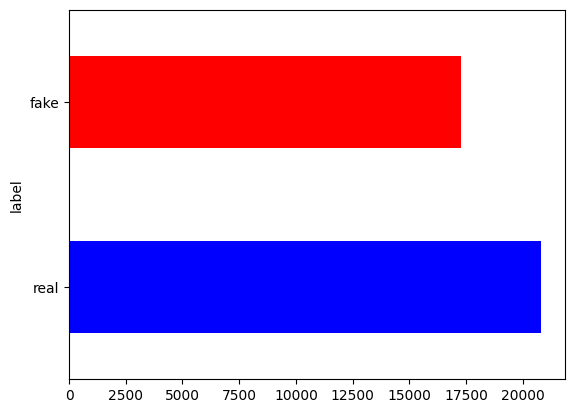

In [160]:
# Get value counts
label_counts = final_data.label.value_counts()
# Define color mapping
colors = ['blue' if label == 'real' else 'red' for label in label_counts.index]
# Plot
label_counts.plot(kind='barh', color=colors)

In [161]:
final_data

,title,text,subject,date,text_length,title_length,text_token_count,title_token_count,cleaned_text,cleaned_title,sentiment,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,2893,79,728,15,Donald Trump just couldn t wish all Americans ...,Donald Trump Sends Out Embarrassing New Year’s...,-0.7096,fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,1898,69,385,11,House Intelligence Committee Chairman Devin Nu...,Drunk Bragging Trump Staffer Started Russian C...,-0.3400,fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,3597,90,928,17,"On Friday, it was revealed that former Milwauk...",Sheriff David Clarke Becomes An Internet Joke ...,-0.2960,fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,2774,78,704,18,"On Christmas day, Donald Trump announced that ...",Trump Is So Obsessed He Even Has Obama’s Name ...,-0.2484,fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,2346,70,475,11,Pope Francis used his annual Christmas Day mes...,Pope Francis Just Called Out Donald Trump Duri...,0.0000,fake
...,...,...,...,...,...,...,...,...,...,...,...,...
38104,North Korea shipments to Syria chemical arms a...,UNITED NATIONS (Reuters) - Two North Korean sh...,worldnews,2017-08-21,2906,76,552,15,Two North Korean shipments to a Syrian governm...,North Korea shipments to Syria chemical arms a...,0.0000,real
38105,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22,800,52,166,11,"LexisNexis, a provider of legal, regulatory an...",LexisNexis withdrew two products from Chinese ...,0.0000,real
38106,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22,1950,49,420,7,In the shadow of disused Soviet-era factories ...,Minsk cultural hub becomes haven from authorities,0.0000,real
38107,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22,1199,61,234,9,Vatican Secretary of State Cardinal Pietro Par...,Vatican upbeat on possibility of Pope Francis ...,0.0000,real


# Train only with titles

In [ ]:
final_data['label'] = final_data['label'].map({'real':1, 'fake':0})
final_data = final_data.sample(frac=1).reset_index(drop=True)
final_data.head()

,title,text,subject,date,date_ordinal,Group,cleaned_text,cleaned_title,label
0,France to give 15 million euros in aid for Syr...,PARIS (Reuters) - France will provide 15 milli...,worldnews,2017-10-20,736622,Real,France will provide 15 million euros ($17.65 m...,France to give 15 million euros in aid for Syr...,1
1,WATCH: We Found Donald Trump’s Campaign Theme...,"Way back in 1998, when Fox s MadTV was still o...",News,2016-01-16,735979,Fake,"Way back in 1998, when Fox s MadTV was still o...",We Found Donald Trump’s Campaign Theme Song,0
2,Hackers Reveal Trump Linked The Most Powerful...,Donald Trump s administration is already provi...,News,2017-01-26,736355,Fake,Donald Trump s administration is already provi...,Hackers Reveal Trump Linked The Most Powerful ...,0
3,WATCH: Sean Spicer’s Debut in “The Bold and t...,President Donald Trump has made one thing clea...,News,2017-04-26,736445,Fake,President Donald Trump has made one thing clea...,Sean Spicer’s Debut in “The Bold and the Babbl...,0
4,New Israeli draft laws seen protecting PM unde...,JERUSALEM (Reuters) - Two of Prime Minister Be...,worldnews,2017-11-17,736650,Real,Two of Prime Minister Benjamin Netanyahu s clo...,New Israeli draft laws seen protecting PM unde...,1


In [ ]:
data_text=final_data["cleaned_title"]
data_label=final_data["label"]

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

2025-04-02 18:01:56.142806: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state = 42)

In [ ]:
# Get the ratio of each category in Y_train
train_ratios = Y_train.value_counts(normalize=True)

# Get the ratio of each category in Y_test
test_ratios = Y_test.value_counts(normalize=True)
# Display the results
print("Category Ratios in Y_train:")
print(train_ratios)

print("\nCategory Ratios in Y_test:")
print(test_ratios)

Category Ratios in Y_train:
label
1    0.649159
0    0.350841
Name: proportion, dtype: float64

Category Ratios in Y_test:
label
1    0.649235
0    0.350765
Name: proportion, dtype: float64


In [ ]:
X_train.to_csv("./input/X_train.csv", index=False)
X_test.to_csv("./input/X_test.csv", index=False)

In [ ]:

maxlen = 100
def tokenize(X):
    tokens = tokenizer(
        text=list(X),
        add_special_tokens=True,
        max_length=maxlen,
        truncation=True,
        padding='max_length',
        return_tensors='tf',
        return_attention_mask=True,
        return_token_type_ids=False,
        verbose=True
    )
    return tokens

In [ ]:
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

In [ ]:
X_train_token

{'input_ids': <tf.Tensor: shape=(26388, 100), dtype=int32, numpy=
array([[  101,  5274, 20119, ...,     0,     0,     0],
       [  101,  5872, 19189, ...,     0,     0,     0],
       [  101,  3524,   112, ...,     0,     0,     0],
       ...,
       [  101,  8499,   156, ...,     0,     0,     0],
       [  101, 24261, 19424, ...,     0,     0,     0],
       [  101,  7661,  1209, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(26388, 100), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
class DistilBertLayer(Layer):
    def __init__(self, distilbert_model, **kwargs):
        super(DistilBertLayer, self).__init__(**kwargs)
        self.distilbert = distilbert_model

    def call(self, inputs):
        # DistilBERT returns a tuple where the first element is the last_hidden_state:
        # shape (batch_size, seq_length, hidden_size)
        outputs = self.distilbert(inputs)
        # Use the embedding of the first token ([CLS] token) as a pooled representation.
        pooled_output = outputs[0][:, 0, :]
        return pooled_output

    def get_config(self):
        config = super(DistilBertLayer, self).get_config()
        config.update({"distilbert_model": None})
        return config

    @classmethod
    def from_config(cls, config):
        # When reloading, you'll need to supply the actual distilbert_model instance.
        distilbert_model = ...  # Update with your own logic if reloading from config.
        return cls(distilbert_model, **config)

def create_model(distilbert_model, maxlen=maxlen):
    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(maxlen,), dtype=tf.int32, name="attention_mask")
    
    distilbert_layer = DistilBertLayer(distilbert_model)
    pooled_output = distilbert_layer({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x = Dropout(0.25)(pooled_output)
    x = Dense(64, activation="tanh")(x)
    x = Dropout(0.35)(x)
    output = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

# Create the model
model = create_model(distilbert_model)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_layer   │ (None, 768)       │          0 │ attention_mask[0… │
│ (DistilBertLayer)   │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 768)       │          0 │ distil_bert_laye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     49,216 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,281 (192.50 KB)

 Trainable params: 49,281 (192.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

/home/martin/FakeNewsNLP/.venv/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

checkpoint_callback = ModelCheckpoint(
    filepath='checkpoints_title/model_{epoch:02d}-{val_loss:.2f}.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
    mode="min"
)


In [ ]:
# Train the model
history = model.fit(
    x={
        'input_ids': X_train_token['input_ids'],
        'attention_mask': X_train_token['attention_mask']
    },
    y=Y_train,
    epochs=5,
    batch_size=9,
    validation_data=(
        {
            'input_ids': X_test_token['input_ids'],
            'attention_mask': X_test_token['attention_mask']
        },
        Y_test
    ),
    callbacks=[early_stopping, reduce_lr, checkpoint_callback]
)

Epoch 1/5
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.6934 - loss: 0.5831
Epoch 1: val_loss improved from inf to 0.13132, saving model to checkpoints_title/model_01-0.13.h5


2932/2932 ━━━━━━━━━━━━━━━━━━━━ 2492s 849ms/step - accuracy: 0.6935 - loss: 0.5830 - val_accuracy: 0.9835 - val_loss: 0.1313 - learning_rate: 1.0000e-05
Epoch 2/5
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.9794 - loss: 0.1356
Epoch 2: val_loss improved from 0.13132 to 0.05846, saving model to checkpoints_title/model_02-0.06.h5


2932/2932 ━━━━━━━━━━━━━━━━━━━━ 2209s 754ms/step - accuracy: 0.9794 - loss: 0.1356 - val_accuracy: 0.9865 - val_loss: 0.0585 - learning_rate: 1.0000e-05
Epoch 3/5
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9868 - loss: 0.0669
Epoch 3: val_loss improved from 0.05846 to 0.04107, saving model to checkpoints_title/model_03-0.04.h5


2932/2932 ━━━━━━━━━━━━━━━━━━━━ 2183s 745ms/step - accuracy: 0.9868 - loss: 0.0669 - val_accuracy: 0.9889 - val_loss: 0.0411 - learning_rate: 1.0000e-05
Epoch 4/5
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.9891 - loss: 0.0473
Epoch 4: val_loss improved from 0.04107 to 0.03458, saving model to checkpoints_title/model_04-0.03.h5


2932/2932 ━━━━━━━━━━━━━━━━━━━━ 2482s 847ms/step - accuracy: 0.9891 - loss: 0.0473 - val_accuracy: 0.9898 - val_loss: 0.0346 - learning_rate: 1.0000e-05
Epoch 5/5
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.9904 - loss: 0.0381
Epoch 5: val_loss improved from 0.03458 to 0.03144, saving model to checkpoints_title/model_05-0.03.h5


2932/2932 ━━━━━━━━━━━━━━━━━━━━ 2392s 816ms/step - accuracy: 0.9904 - loss: 0.0381 - val_accuracy: 0.9901 - val_loss: 0.0314 - learning_rate: 1.0000e-05


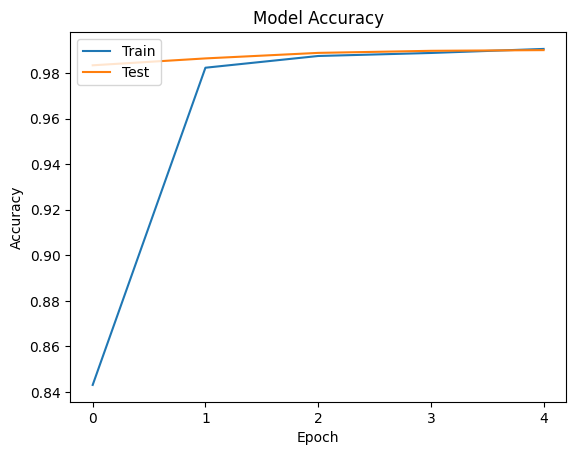

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.xticks([0, 1, 2, 3, 4])
plt.show()

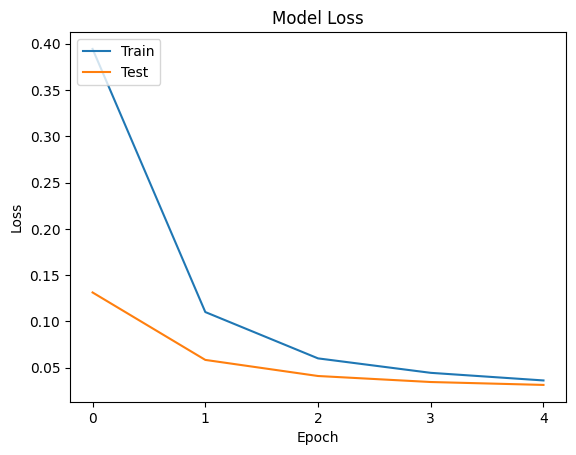

In [ ]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.xticks([0, 1, 2, 3, 4])
plt.show()

In [ ]:
# Make predictions
y_pred_proba = model.predict({
    'input_ids': X_test_token['input_ids'],
    'attention_mask': X_test_token['attention_mask']
})

# Convert probabilities to binary predictions
y_pred = np.where(y_pred_proba >= 0.5, 1, 0)

207/207 ━━━━━━━━━━━━━━━━━━━━ 545s 3s/step


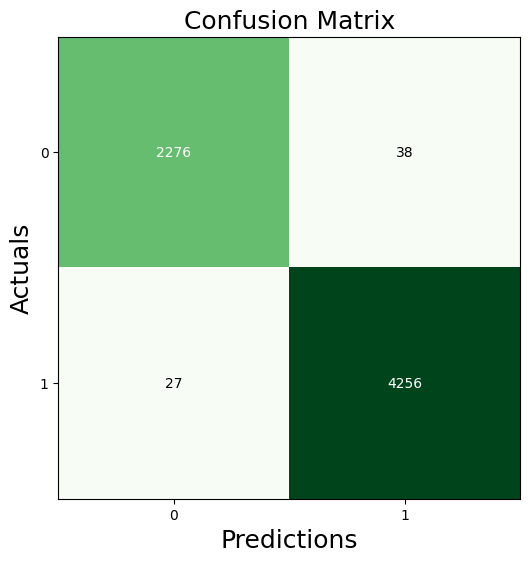

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(Y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Train with only texts

In [ ]:
# final_data["titleAndText"]=final_data["cleaned_title"] +": " + final_data["cleaned_text"]
# final_data=final_data[["titleAndText","label"]]
# final_data['label'] = final_data['label'].map({'real':1, 'fake':0})
# final_data = final_data.sample(frac=1).reset_index(drop=True)
# final_data.head()

In [ ]:
data_text=final_data["cleaned_text"]
data_label=final_data["label"]

In [ ]:
# final_data[["titleAndText","label"]].to_csv("./input/final_data.csv", index=False)

In [ ]:
# bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')
# tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
# bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state = 42)

In [ ]:

maxlen = 512
def tokenize(X):
    tokens = tokenizer(
        text=list(X),
        add_special_tokens=True,
        max_length=maxlen,
        truncation=True,
        padding='max_length',
        return_tensors='tf',
        return_attention_mask=True,
        return_token_type_ids=False,
        verbose=True
    )
    return tokens

In [ ]:
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

In [ ]:
X_train_token

{'input_ids': <tf.Tensor: shape=(26388, 512), dtype=int32, numpy=
array([[  101,  1057,  1012, ...,     0,     0,     0],
       [  101,  2610,  1999, ...,     0,     0,     0],
       [  101,  6142,  2343, ...,     0,     0,     0],
       ...,
       [  101,  2009,  1055, ...,  1997,  5841,   102],
       [  101,  3008,  2040, ...,  6535,  3867,   102],
       [  101,  2343, 13857, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(26388, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
class DistilBertLayer(Layer):
    def __init__(self, distilbert_model, **kwargs):
        super(DistilBertLayer, self).__init__(**kwargs)
        self.distilbert = distilbert_model

    def call(self, inputs):
        # DistilBERT returns a tuple where the first element is the last_hidden_state:
        # shape (batch_size, seq_length, hidden_size)
        outputs = self.distilbert(inputs)
        # Use the embedding of the first token ([CLS] token) as a pooled representation.
        pooled_output = outputs[0][:, 0, :]
        return pooled_output

    def get_config(self):
        config = super(DistilBertLayer, self).get_config()
        config.update({"distilbert_model": None})
        return config

    @classmethod
    def from_config(cls, config):
        # When reloading, you'll need to supply the actual distilbert_model instance.
        distilbert_model = ...  # Update with your own logic if reloading from config.
        return cls(distilbert_model, **config)

def create_model(distilbert_model, maxlen=maxlen):
    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(maxlen,), dtype=tf.int32, name="attention_mask")
    
    distilbert_layer = DistilBertLayer(distilbert_model)
    pooled_output = distilbert_layer({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x = Dropout(0.25)(pooled_output)
    x = Dense(64, activation="tanh")(x)
    x = Dropout(0.35)(x)
    output = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

# Create the model
model = create_model(distilbert_model)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_layer_1 │ (None, 768)       │          0 │ attention_mask[0… │
│ (DistilBertLayer)   │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 768)       │          0 │ distil_bert_laye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     49,216 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,281 (192.50 KB)

 Trainable params: 49,281 (192.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

/home/martin/FakeNewsNLP/.venv/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

checkpoint_callback = ModelCheckpoint(
    filepath='checkpoints_text/model_{epoch:02d}-{val_loss:.2f}.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
    mode="min"
)




In [ ]:
# Train the model
history = model.fit(
    x={
        'input_ids': X_train_token['input_ids'],
        'attention_mask': X_train_token['attention_mask']
    },
    y=Y_train,
    epochs=5,
    batch_size=9,
    validation_data=(
        {
            'input_ids': X_test_token['input_ids'],
            'attention_mask': X_test_token['attention_mask']
        },
        Y_test
    ),
    callbacks=[early_stopping, reduce_lr, checkpoint_callback]
)

Epoch 1/5
 932/2932 ━━━━━━━━━━━━━━━━━━━━ 2:35:46 5s/step - accuracy: 0.6212 - loss: 0.6448

KeyboardInterrupt: 

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Make predictions
y_pred_proba = model.predict({
    'input_ids': X_test_token['input_ids'],
    'attention_mask': X_test_token['attention_mask']
})

# Convert probabilities to binary predictions
y_pred = np.where(y_pred_proba >= 0.5, 1, 0)

In [ ]:
# Plot confusion matrix
# from mlxtend.plotting import plot_confusion_matrix
conf_matrix = confusion_matrix(Y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()